In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from bloqade.analog import cast, load, save, start

if not os.path.isdir("data"):
    os.mkdir("data")


## Assign values to the variables in the program,
Once your program is built, you can use the `assign` method to assign values to the variables in the program. These values must be numeric, and can be either `int`, `float`, or `Decimal` (from the `decimal` module). Note that the `Decimal` type is used to represent real numbers exactly, whereas `float` is a 64-bit floating point number that is only accurate to about 15 decimal places. The `Decimal` type is recommended for Bloqade programs, as it will ensure that your program is simulated and run with the highest possible precision. We can also do a parameter scan using the  `batch_assign` method, which will create a different program for each value provided in the list. In this case, we are sweeping the `run_time` variable, which is the time that the Rabi amplitude stays at the value of `rabi_ampl`.

In [2]:

durations = cast(["ramp_time", "run_time", "ramp_time"])

rabi_oscillations_program = (
    start.add_position((0, 0))
    .rydberg.rabi.amplitude.uniform.piecewise_linear(
        durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0]
    )
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)


run_times = np.linspace(0, 3, 101)

rabi_oscillation_job = rabi_oscillations_program.assign(
    ramp_time=0.06, rabi_ampl=15, detuning_value=0.0
).batch_assign(run_time=run_times)

## Run Emulator and Hardware
To run the program on the emulator we can select the `bloqade` provider as a property of the `batch` object. Bloqade has its own emulator that we can use to run the program. To do this select `python()` as the next option followed by the `run` method. Then we dump the results to a file so that we can use them later. Note that unlike the actual hardware  the shots do not correspond to multiple executions of the emulator but rather the number of times the final wavefunction is sampled. This is because the emulator does not simulate any noise.

In [3]:
emu_filename = os.path.join(os.path.abspath(""), "data", "rabi-emulation.json")

raise Exception("We have already saved the emulation data, so we don't need to run this again.")

if not os.path.isfile(emu_filename):
    emu_batch = rabi_oscillation_job.bloqade.python().run(10000)
    save(emu_batch, emu_filename)

Exception: We have already saved the emulation data, so we don't need to run this again.

When running on the hardware we can use the `braket` provider. However, we will need to specify the device to run on. In this case we will use *Aquila* via the `aquila` method. Before that we must note that because Aquila can support up to 256 atoms in an area that is $75 \times 76 \mu m^2$. We need to make full use of the capabilities of the device. Bloqade automatically takes care of this with the `parallelize` method, which will allow us to run multiple copies of the program in parallel using the full user provided area of Aquila. The `parallelize` method takes a single argument, which is the distance between each copy of the program on a grid. In this case, we want to make sure that the distance between each atom is at least 24 micrometers, so that the Rydberg interactions between atoms are negligible.

To run the program but not wait for the results, we can use the `run_async` method, which will return a `Batch` object that can be used to fetch the results later. After running the program, we dump the results to a file so that we can use them later. Note that if you want to wait for the results in the python script just call the `run` method instead of `run_async`. This will block the script until all results in the batch are complete.

<div class="admonition danger">
<p class="admonition-title">Hardware Execution Cost</p>
<p>

For this particular program, 101 tasks are generated with each task having 1000 shots, amounting to __USD \\$1040.30__ on AWS Braket.

</p>
</div>

In [ ]:
hardware_filename = os.path.join(os.path.abspath(""), "data", "rabi-job.json")

raise Exception("Don't run this! You can do a lot more than this with 101,000 shots!")

if not os.path.isfile(hardware_filename):
    batch = rabi_oscillation_job.parallelize(24).braket.aquila().run_async(1000)
    save(batch, hardware_filename)

Exception: Don't run this! You can do a lot more than this with 101,000 shots!

## Plotting the Results
The quantity of interest in this example is the probability of finding the atom in the Rydberg state, which is given by the `0` measurement outcome. The reason that `0` is the Rydberg state is because the in the actual device the Rydberg atoms are pushed out of the trap area and show up as a dark spot in the image. To get the probability of being in the Rydberg state, we can use the `bitstrings` method of the `Report` object, which returns a list of numpy arrays containing the measurement outcomes for each shot. We can then use the `mean` method of the numpy array to get the probability of being in the Rydberg state for each shot. We can then plot the results as a function of time. the time value can be obtained from the `run_time` parameter of the `Report` object as a list.

before that we need to load the results from our previously saved files using the `load` function from bloqade.analog:

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/var/folders/rt/16bvzf7n6gv2vjz346nck1rc0000gq/T/ipykernel_94105/2719656522.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


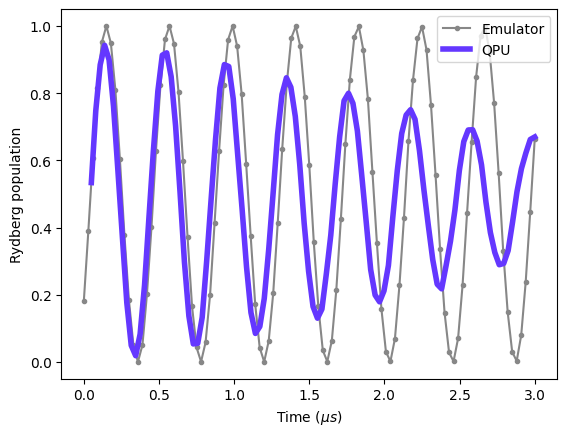

In [ ]:
emu_batch = load(emu_filename)
hardware_batch = load(hardware_filename)
# hardware_batch.fetch()
# save(filename, hardware_batch)

# %%
hardware_report = hardware_batch.report()
emulator_report = emu_batch.report()

times = emulator_report.list_param("run_time")
density = [1 - ele.mean() for ele in emulator_report.bitstrings()]
plt.plot(times, density, color="#878787", marker=".", label="Emulator")

times = hardware_report.list_param("run_time")
density = [1 - ele.mean() for ele in hardware_report.bitstrings()]
plt.plot(times, density, color="#6437FF", linewidth=4, label="QPU")

plt.xlabel("Time ($\mu s$)")
plt.ylabel("Rydberg population")
plt.legend()
plt.show()